## Link GDL ADM1 to ADM2


This notebook is used to link ADM2 shapefiles to the ADM1 shapefiles that we have from the Global Data Lab (GDL). 

Throughout the paper, we want to be consistent about what our ADM1 observations are. Because ADM2 observations come from a different source, we also need to hierarchialy link GDL ADM1 observations to the ADM2 observations that are available.

Finally, we need to ensure that any ADM2 observations that are approximately the same as an ADM1 observation (due to data quality issues) are not included in any super-resolution tests.

In [1]:
import os

repo_dir = os.environ.get("REPO_DIR")
data_dir = os.path.join(repo_dir, "data/")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

import shapely

In [2]:
gpdf = pd.read_pickle(data_dir + "int/GDL_HDI/HDI_ADM1_shapefile_clean.p").reset_index()

In [3]:
adm2 = gpd.read_file(data_dir + "raw/geoBoundaries/geoBoundariesCGAZ_ADM2.geojson")

Quick inspection of the ADM2 raw data:

In [4]:
adm2s_per_country = adm2.groupby("shapeGroup").count()["geometry"]

In [5]:
adm2s_per_country[adm2s_per_country > 500] # Ireland has 50,000 ADM2 observations. This is half the dataset...

shapeGroup
ARG      527
AUS      559
BRA     5585
COL     1122
CYP      609
DZA      547
ESP     8203
GBR     9120
HRV      556
IDN      518
IND      641
IRL    50374
JPN     1732
MEX     2458
NGA      773
ROU     3235
RUS     2322
THA      928
TUR      969
UKR      680
USA     3232
VNM      774
Name: geometry, dtype: int64

## First, we illustrate the concepual goal with one country (Ethiopia)

In [6]:
country_code = "ETH"

In [7]:
adm1_subset = gpdf[gpdf["iso_code"] == country_code]
adm2_subset = adm2[adm2["shapeGroup"] == country_code]

 We want to match adm2 polygons to their parents (from another source)

<AxesSubplot:>

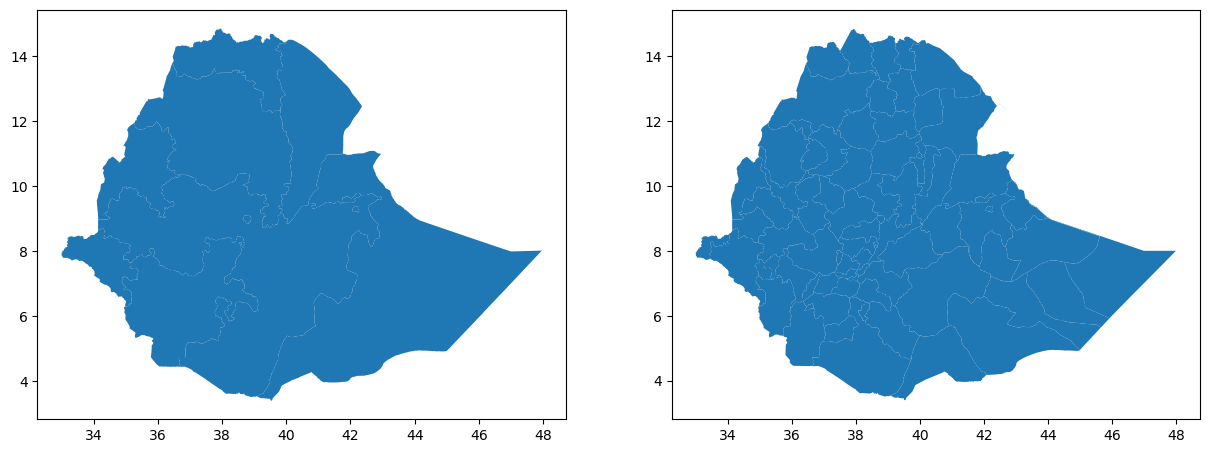

In [8]:

fig, ax = plt.subplots(1,2, figsize=(15,10))

adm1_subset.plot(ax=ax[0])
adm2_subset.plot(ax=ax[1])

## Run an example

In [9]:
def get_adm1_adm2_intersection_for_country(country_code, adm1=gpdf, adm2=adm2):
    
    """
    This function takes the two polygons and calculates the overlap, including the % overlap. 
    
    It returns a merged geodataframe object
    
    """
    adm1_subset = adm1[adm1["iso_code"] == country_code]
    adm2_subset = adm2[adm2["shapeGroup"] == country_code]
    
    overlaps_list = []
    percentages_list = []
    for adm2_geometry in adm2_subset["geometry"]:
        bools = adm1_subset.intersects(adm2_geometry)
        overlaps = list(adm1_subset["GDLCODE"].loc[bools])
        percentages = list(adm1_subset.loc[bools].intersection(adm2_geometry).area / adm2_geometry.area)

        overlaps_list.append(overlaps)
        percentages_list.append(percentages)

    adm2_subset_copy = adm2_subset.copy()
    adm2_subset_copy["overlaps"] = overlaps_list
    adm2_subset_copy["percent_overlaps"] = percentages_list
    
    return adm2_subset_copy
    

In [10]:
# example = get_adm1_adm2_intersection_for_country("ETH")
# example.head()

## Now we repeat the process for all countries and concetenate the outputs

In [11]:
country_codes = gpdf["iso_code"].unique()

This intersection calculation is slow so we comment out and save the intermediate output.

In [36]:
# dfs = []

# for country_code in country_codes:
#     print(country_code)
#     dfs.append(get_adm1_adm2_intersection_for_country(country_code))
# output_df = pd.concat(dfs)

In [13]:
int_outpath = data_dir + "int/ADM2_to_GDL_link/int_file_adm2_polygons_linked_to_GDL_adm1.p"
output_df.to_pickle(int_outpath)

In [14]:
output_df = pd.read_pickle(int_outpath)

In [15]:
output_df.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,ADM1_shapeID,ADM0_shapeID,ADMHIERARCHY,geometry,overlaps,percent_overlaps
1358,Kota Batu,None,BRN-ADM2-3_0_0-B1,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B1|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 114.99643 4.94485...",[BRNt],[0.869973572327033]
1359,Kilanas,None,BRN-ADM2-3_0_0-B2,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B2|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((114.90051 4.87061, 114.87530 4.86444...",[BRNt],[1.0]
1360,Tanjong Maya,None,BRN-ADM2-3_0_0-B3,BRN,ADM2,BRN-ADM1-3_0_0-B4,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B3|BRN-ADM1-3_0_0-B4|BRN-ADM0-3...,"POLYGON ((114.70729 4.75307, 114.66990 4.78399...",[BRNt],[0.9999999999999999]
1361,Serasa,None,BRN-ADM2-3_0_0-B4,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B4|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.04237 4.96770, 115.04136 4.97294...",[BRNt],[0.961190516435816]
1362,Mentiri,None,BRN-ADM2-3_0_0-B5,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B5|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 115.01859 4.93775...",[BRNt],[0.9923242896225125]


### Now we are going to do further processing before we finalize the linking

In [16]:
def max_overlap(x):
    if x  == []:
        return None
    else:
        return max(x)

In [17]:
overlap_dist = (output_df["percent_overlaps"].apply(max_overlap))

Visually inspect the max percent overlap of the ADM2 polygons. This looks quite good

Text(0.5, 1.0, 'ADM2 obs overlap perc with ADM1 obs')

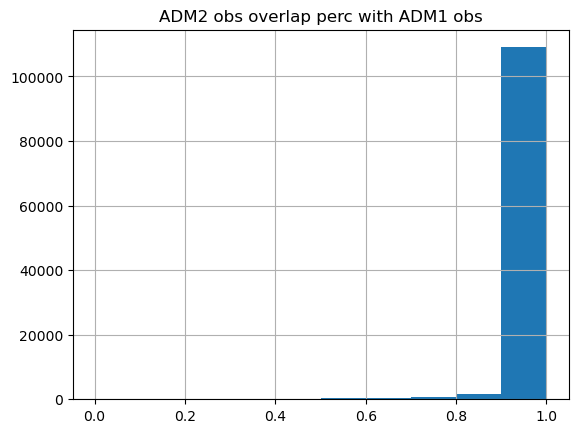

In [18]:
overlap_dist.hist()
plt.title("ADM2 obs overlap perc with ADM1 obs")

### Based on this data, we are going to drop ADM2 polygons that have less than 50% intersection with the GDL ADM1 polygons.
For these, we can't be sure that we are matching correctly.

In [19]:
print("Dropped ADM2 observations -- because there is no intersection or intersection is less than 50% of the adm2 area:")
drop_count = np.isnan(overlap_dist).sum() + (overlap_dist < .5).sum()
print(drop_count)
print("\n")

print(f"We are dropping {round(drop_count/len(adm2) * 100,2)}% of the ADM2 observations")

Dropped ADM2 observations -- because there is no intersection or intersection is less than 50% of the adm2 area:
466


We are dropping 0.41% of the ADM2 observations


In [20]:
keep_idxs = ~(np.isnan(overlap_dist) | (overlap_dist < .5))
output_df_drop = output_df.copy()[keep_idxs]

In [21]:
arg_maxes = output_df_drop["percent_overlaps"].apply(np.argmax)

In [22]:
output_df_drop.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,ADM1_shapeID,ADM0_shapeID,ADMHIERARCHY,geometry,overlaps,percent_overlaps
1358,Kota Batu,None,BRN-ADM2-3_0_0-B1,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B1|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 114.99643 4.94485...",[BRNt],[0.869973572327033]
1359,Kilanas,None,BRN-ADM2-3_0_0-B2,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B2|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((114.90051 4.87061, 114.87530 4.86444...",[BRNt],[1.0]
1360,Tanjong Maya,None,BRN-ADM2-3_0_0-B3,BRN,ADM2,BRN-ADM1-3_0_0-B4,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B3|BRN-ADM1-3_0_0-B4|BRN-ADM0-3...,"POLYGON ((114.70729 4.75307, 114.66990 4.78399...",[BRNt],[0.9999999999999999]
1361,Serasa,None,BRN-ADM2-3_0_0-B4,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B4|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.04237 4.96770, 115.04136 4.97294...",[BRNt],[0.961190516435816]
1362,Mentiri,None,BRN-ADM2-3_0_0-B5,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B5|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 115.01859 4.93775...",[BRNt],[0.9923242896225125]


In [23]:
final_overlap_percentages = [output_df_drop["percent_overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]
final_overlap_adm1 = [output_df_drop["overlaps"].iloc[i][item] for i,item in enumerate(arg_maxes)]

In [24]:
final_adm2_process = output_df_drop.drop(["overlaps", "percent_overlaps"], axis=1)

In [25]:
final_adm2_process["GDL_ADM1"] = final_overlap_adm1
final_adm2_process["percent_overlap_GDL_ADM1"] = np.round(np.array(final_overlap_percentages)*100,2)

In [26]:
final_adm2_process.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,ADM1_shapeID,ADM0_shapeID,ADMHIERARCHY,geometry,GDL_ADM1,percent_overlap_GDL_ADM1
1358,Kota Batu,None,BRN-ADM2-3_0_0-B1,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B1|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 114.99643 4.94485...",BRNt,87.00
1359,Kilanas,None,BRN-ADM2-3_0_0-B2,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B2|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((114.90051 4.87061, 114.87530 4.86444...",BRNt,100.00
1360,Tanjong Maya,None,BRN-ADM2-3_0_0-B3,BRN,ADM2,BRN-ADM1-3_0_0-B4,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B3|BRN-ADM1-3_0_0-B4|BRN-ADM0-3...,"POLYGON ((114.70729 4.75307, 114.66990 4.78399...",BRNt,100.00
1361,Serasa,None,BRN-ADM2-3_0_0-B4,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B4|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.04237 4.96770, 115.04136 4.97294...",BRNt,96.12
1362,Mentiri,None,BRN-ADM2-3_0_0-B5,BRN,ADM2,BRN-ADM1-3_0_0-B3,BRN-ADM0-3_0_0-B1,BRN-ADM2-3_0_0-B5|BRN-ADM1-3_0_0-B3|BRN-ADM0-3...,"POLYGON ((115.01400 4.93203, 115.01859 4.93775...",BRNt,99.23


### Check that no polygons are getting the wrong country assigned after this process:

In [27]:
all(final_adm2_process["shapeGroup"] == final_adm2_process["GDL_ADM1"].apply(lambda x: x[:3]))

True

### One last check -- see if ADM1 polygon has only 1 ADM2 observation

In [28]:
adm2s_per_adm1 = final_adm2_process.groupby("GDL_ADM1").count()["shapeName"]

In [29]:
adm2s_per_adm1.sort_values(ascending=False).head(20)

GDL_ADM1
IRLr101    9823
IRLr103    9547
IRLr107    9280
IRLr108    7969
IRLr102    4440
IRLr106    4239
IRLr105    4034
ESPr109    2298
GBRr108    1407
GBRr106    1057
IRLr104    1004
GBRr109     998
ESPr112     948
ESPr110     921
GBRr102     921
GBRr104     882
BRAr117     852
GBRr110     850
ESPr115     779
GBRr105     744
Name: shapeName, dtype: int64

Text(0.5, 1.0, 'ADM2 obs per ADM1')

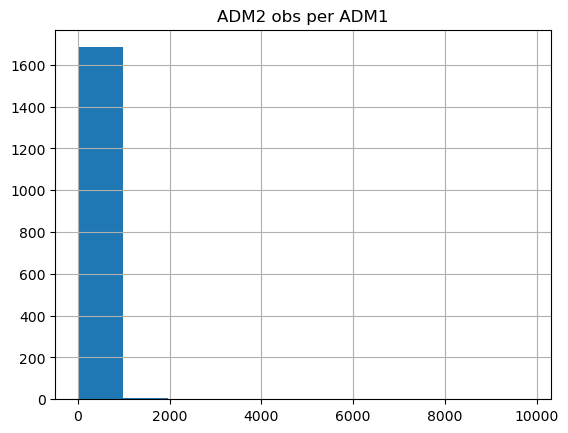

In [30]:
adm2s_per_adm1.hist()
plt.title("ADM2 obs per ADM1")

In [31]:
single_adm2 = (adm2s_per_adm1 ==1)
print(f" { single_adm2.sum()} ADM1 observations have a single ADM2 observation")

 109 ADM1 observations have a single ADM2 observation


This isn't necessarily a problem -- just a phenomenon that we want to be aware of. It's a very small percentage of our ADM2 observations.

In [32]:
adm1_has_one_adm2 = gpdf.set_index("GDLCODE").loc[single_adm2.index[single_adm2]]
adm1_has_one_adm2.head(15)

,continent,iso_code,geometry
GDL_ADM1,,,
ARMr111,Europe,ARM,"POLYGON ((44.41855 40.21835, 44.41855 40.23283..."
AUTr103,Europe,AUT,"POLYGON ((16.22044 48.13174, 16.23200 48.13318..."
AZEr101,Europe,AZE,"MULTIPOLYGON (((49.44503 39.81242, 49.44904 39..."
BELr101,Europe,BEL,"POLYGON ((4.40336 50.77439, 4.40352 50.77405, ..."
BELr102,Europe,BEL,"MULTIPOLYGON (((4.32341 51.20192, 4.32000 51.2..."
BELr103,Europe,BEL,"MULTIPOLYGON (((5.79906 50.72372, 5.79614 50.7..."
BELr104,Europe,BEL,"POLYGON ((3.67587 50.76648, 3.67325 50.76197, ..."
BELr105,Europe,BEL,"POLYGON ((5.05329 50.72244, 5.05450 50.72420, ..."
BELr106,Europe,BEL,"MULTIPOLYGON (((2.92090 50.75974, 2.91760 50.7..."


### Now we write the output file

In [33]:
outpath = data_dir + "int/ADM2_to_GDL_link/adm2_polygons_linked_to_GDL_adm1.p"

In [34]:
final_adm2_process.to_pickle(outpath)

<AxesSubplot:>

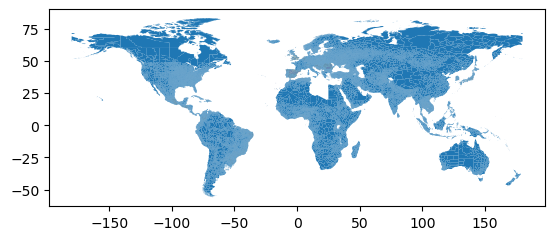

In [35]:
final_adm2_process.plot()